# SuperVoice dVAE evaluation
This notebook provides tools for dVAE evaluation

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Local
from dvae.model import DiscreteVAE
from utils.misc import plot_specgram, plot_waveform
from utils.audio import spectogram, load_mono_audio
from train_config import config

### Environment

In [2]:
# Parameters
device = torch.device('cuda:0')
checkpoint = "./checkpoints/dvae_sr_24khz.pt"

# Device and Model
dvae = DiscreteVAE(
    # Base mel spec parameters
    positional_dims=1,
    channels=config.audio.num_mels,

    # Number of possible tokens
    num_tokens=config.dvae.tokens,

    # Architecture
    codebook_dim=config.dvae.codebook_dim,
    hidden_dim=config.dvae.hidden_dim,
    num_resnet_blocks=config.dvae.num_resnet_blocks,
    kernel_size=config.dvae.kernel_size,
    num_layers=config.dvae.num_layers,
    use_transposed_convs=False,
).to(device)

# Load checkpoint
data = torch.load(checkpoint)
dvae.load_state_dict(data['dvae'])

# Switch to eval
dvae.eval()

DiscreteVAE(
  (discrete_loss): DiscretizationLoss()
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(80, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (2): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (4): ResBlock(
      (net): Sequential(
        (0):

# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

torch.Size([1, 192]) torch.Size([80, 766]) torch.Size([80, 768])
tensor([[6751,  242, 6751,  242,  242,  242,  242,  242,  242,  242,  242, 6751,
          242,  242, 7357, 7357, 6751, 6751, 6751, 6751, 6751, 6751, 6751, 2662,
         6751,  242, 2662, 6751,  242,  242,  242,  242,  242,  242,  242,  242,
          242, 6751, 7357, 2662,  242,  242,  242, 7357, 7357, 7357, 6751, 6751,
          242,  242,  242,  242,  242,  242,  242, 2885, 2662, 2662,  242,  242,
          242,  242,  242, 7357, 6751,  242,  242,  242,  242,  242,  242, 6751,
         6751,  242,  242,  242, 7357, 7357, 7357, 7357, 7357, 7357, 7357, 7357,
         7357, 7357, 7357,  242,  242, 7357, 7357, 7357, 7357,  242,  242, 7357,
         7357,  242, 6751,  242, 6751, 7357, 7357, 7357,  242,  242,  242,  242,
          242,  242,  242,  242,  242,  242,  242,  242,  242,  242,  242,  242,
          242,  242,  242,  242,  242,  242, 2662, 2662, 2662, 2662, 2662,  242,
         6751, 6751, 6751, 6751,  242,  242,

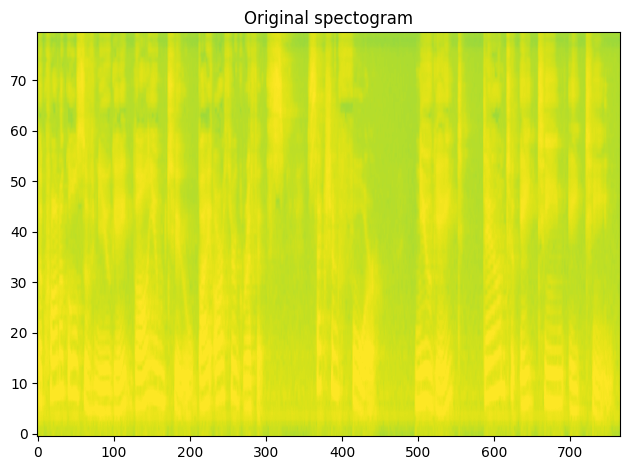

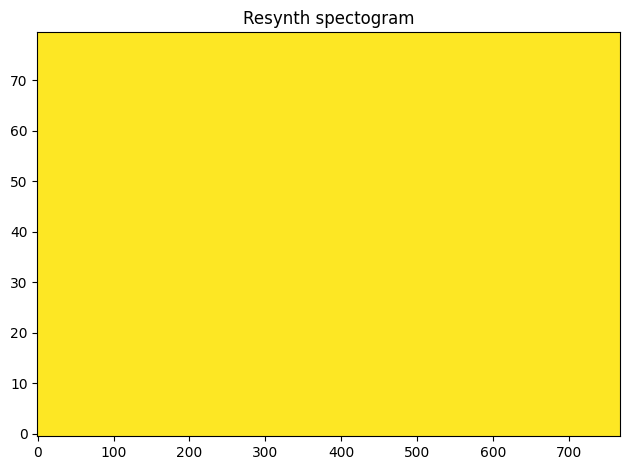

In [7]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", config.audio.sample_rate)
else:
    test = load_mono_audio("./external_datasets/lj-speech-1.1/wavs/LJ002-0001.wav", config.audio.sample_rate)
spec = spectogram(test, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)

# Generate
codes = dvae.get_codebook_indices(spec.unsqueeze(0).to(device))
codes_spec, _ = dvae.infer(spec.unsqueeze(0).to(device))
codes_spec = codes_spec.detach().cpu().squeeze(0)

print(codes.shape, spec.shape, codes_spec.shape)

print(codes)
print(spec)
print(codes_spec)

# resynth = dvae generator(spec.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
# resynth_spec = spectogram(resynth, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(codes_spec.cpu(), title="Resynth spectogram")
# plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / config.audio.sample_rate))
# plot_waveform(resynth,xlim=(0,len(test) / config.audio.sample_rate))
# display(Audio(data=test, rate=config.audio.sample_rate))
# display(Audio(data=resynth, rate=config.audio.sample_rate))